<a href="https://colab.research.google.com/github/m4riod14z/SkinDiseasesRNC/blob/main/EfficientNetV2B0_EarlyStopping_y_ModelCheckpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, itertools
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

plt.rcParams["figure.dpi"] = 120
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE = "/content/drive/MyDrive/SkinDiseasesRNC/Dataset"
TRAIN_DIR = os.path.join(BASE, "train")
TEST_DIR  = os.path.join(BASE, "test")

print("Train existe:", os.path.isdir(TRAIN_DIR))
print("Test  existe:", os.path.isdir(TEST_DIR))

Train existe: True
Test  existe: True


In [ ]:
IMG_SIZE = (384, 384)
BATCH = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=0.2, subset="training", seed=SEED
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=0.2, subset="validation", seed=SEED
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH, shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases (orden):", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

Found 1045 files belonging to 4 classes.
Using 836 files for training.
Found 1045 files belonging to 4 classes.
Using 209 files for validation.
Found 447 files belonging to 4 classes.
Clases (orden): ['Acne', 'Atopic_Dermatitis', 'Psoriasis', 'Rosacea']


In [ ]:
base = keras.applications.EfficientNetV2B0(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,)
)
base.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = keras.applications.efficientnet_v2.preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="efficientnetv2b0")

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "efficientnetv2b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 12, 12, 1280)   │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,796 (23.21 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
PATH = "/content/drive/MyDrive/efficienteNetV2B0_best.keras"

callbacksTrain = [
    keras.callbacks.ModelCheckpoint(
        filepath=PATH,
        save_best_only=True,
        monitor="val_accuracy",
        mode="max",
        verbose=1
    ),

    keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor="val_accuracy",
        verbose=1
    )
]

In [ ]:
EPOCHS = 25
history = model.fit(
    train_ds, validation_data=val_ds,
    epochs=EPOCHS, callbacks=callbacksTrain,
)

Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5704 - loss: 1.0023
Epoch 1: val_accuracy improved from -inf to 0.82775, saving model to best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 339s 6s/step - accuracy: 0.5721 - loss: 0.9986 - val_accuracy: 0.8278 - val_loss: 0.4550
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7852 - loss: 0.5677
Epoch 2: val_accuracy improved from 0.82775 to 0.87560, saving model to best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.7857 - loss: 0.5662 - val_accuracy: 0.8756 - val_loss: 0.3619
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8370 - loss: 0.4280
Epoch 3: val_accuracy did not improve from 0.87560
53/53 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.8374 - loss: 0.4268 - val_accuracy: 0.8756 - val_loss: 0.3456
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8702 - loss: 0.3362
Epoch 4: val_accuracy did not improve from 0.87560
53/53 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.8

In [ ]:
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

In [ ]:
probs = model.predict(test_ds, verbose=0)
y_pred = probs.argmax(axis=1)

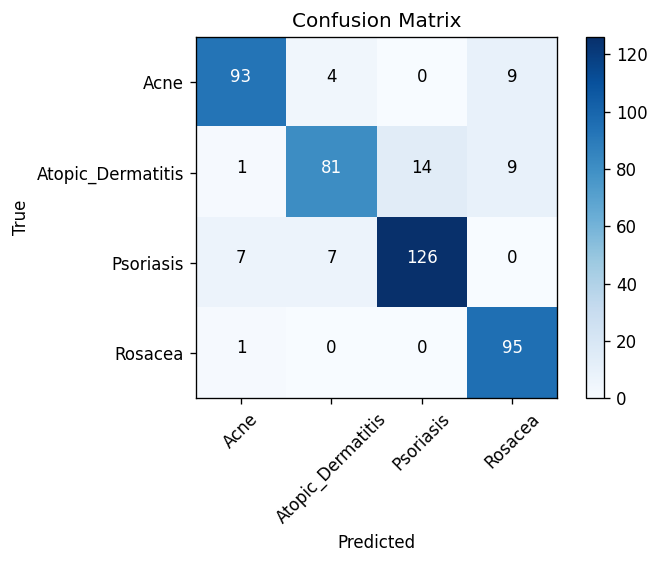

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)
th = cm.max() / 2.0
for i, j in itertools.product(range(num_classes), range(num_classes)):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > th else "black")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

                   precision    recall  f1-score   support

             Acne     0.8981    0.9151    0.9065       106
Atopic_Dermatitis     0.8600    0.8190    0.8390       105
        Psoriasis     0.9085    0.9214    0.9149       140
          Rosacea     0.9278    0.9375    0.9326        96

         accuracy                         0.8993       447
        macro avg     0.8986    0.8983    0.8983       447
     weighted avg     0.8988    0.8993    0.8989       447



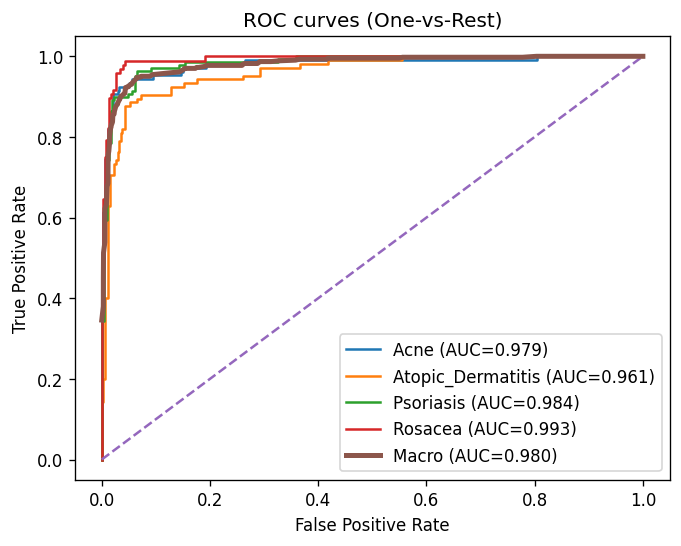

In [ ]:
y_bin = label_binarize(y_true, classes=list(range(num_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Graficar
plt.figure()
for i, name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f"{name} (AUC={roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], '--')
plt.plot(all_fpr, mean_tpr, label=f"Macro (AUC={roc_auc['macro']:.3f})", linewidth=3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (One-vs-Rest)")
plt.legend()
plt.show()